# Kernel Tuner Simulation Mode Test

This notebook is intended to examine the completeness, consistency, and advantage of simulation mode in Kernel Tuner.

In [1]:
from pathlib import Path
import json
import re
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from warnings import warn
from typing import Tuple

cachedirectory = Path("kernels/outputdata/simulation_mode")
savedirectory = Path(Path.cwd(), "figures", "simulation_mode")
mpl.rcParams["savefig.directory"] = savedirectory

In [2]:
# arguments
kernelname = "gemm_cltune_opencl"
expected_keys_env = ['execution_time', 'overhead_time', 'total_benchmark_time', 'total_verification_time', 'total_compile_time', 'total_strategy_time', 'total_framework_time']
expected_keys_cache = ['time', 'times', 'GFLOP/s', 'temperature', 'compile_time', 'benchmark_time', 'verification_time', 'framework_time', 'strategy_time']

algorithm_displaynames = {
    'brute': "bruteforce",
    'random': "random",
}

plot_height = 6
plot_aspect = 2.0
plot_dpi = 250
sns.set_theme(rc={'figure.figsize':(plot_height*plot_aspect,plot_height)})

In [3]:
def get_dataframes() -> Tuple[pd.DataFrame, pd.DataFrame]:

    # collect the relevant cachefiles
    cachefiles : list[Path] = []
    for file in cachedirectory.iterdir():
        if file.is_file() and file.name.startswith(kernelname) and file.name.endswith('_output.json'):
            cachefiles.append(file)

    # create a list of dictionaries of the data
    cache_dicts = list()
    env_dicts = list()
    for filepath in cachefiles:
        # load the data
        envfilepath = Path(str(filepath).replace('_output', '_env'))
        assert envfilepath.exists()
        try:
            cachefile = json.load(filepath.open())
            envfile = json.load(envfilepath.open())
        except json.JSONDecodeError:
            warn(f"Could not load cachefile {filepath.name}")
            continue
        assert isinstance(cachefile, list)
        assert isinstance(envfile, dict)

        # combine the data into a dictionary
        device_name = envfile['device_name']
        is_simulated = "_mode=simulated" in filepath.name
        mode = 'simulated' if is_simulated else 'real'
        algorithm = algorithm_displaynames[re.search(r"_alg=([a-zA-Z]+)_", filepath.name).group(1).strip()]
        # for each of the tuned configurations, create a dictionary with the expected items
        for value in cachefile:
            assert isinstance(value, dict)
            cache = {}
            cache['device_name'] = device_name
            cache['algorithm'] = algorithm
            cache['simulated'] = is_simulated
            cache['mode'] = mode
            for key in expected_keys_cache:
                cache[key] = value[key]
            cache['total_time'] = value['strategy_time'] + value['compile_time'] + value['benchmark_time'] + value['verification_time'] + value['framework_time']
            cache_dicts.append(cache)
        # create a global dictionary per tuning session
        env = {}
        env['device_name'] = device_name
        env['algorithm'] = algorithm
        env['simulated'] = is_simulated
        env['mode'] = mode
        for key in expected_keys_env:
            env[key] = envfile[key]
        env_dicts.append(env)

    # create a dataframe out of the dictionaries
    df_cache = pd.DataFrame(cache_dicts)
    df_env = pd.DataFrame(env_dicts)
    return df_cache, df_env

In [4]:
df_cache, df_env = get_dataframes()
df_cache

,device_name,algorithm,simulated,mode,time,times,GFLOP/s,temperature,compile_time,benchmark_time,verification_time,framework_time,strategy_time,total_time
0,NVIDIA RTX A4000,random,False,real,50.986464,"[50.937856, 50.958335999999996, 51.00748799999...",2696.254988,63.938837,64.226324,2675.643970,0,0.000000,337.325874,3077.196168
1,NVIDIA RTX A4000,random,False,real,35.153216,"[35.654655999999996, 35.31264, 34.991104, 35.1...",3910.666606,64.596712,203.389203,2170.885920,0,1.975150,0.008175,2376.258448
2,NVIDIA RTX A4000,random,False,real,56.686333,"[56.691711999999995, 56.691711999999995, 56.69...",2425.143780,64.903373,203.106314,2865.340076,0,2.076749,0.008937,3070.532076
3,NVIDIA RTX A4000,random,False,real,29.817951,"[29.532159999999998, 30.047231999999997, 29.83...",4610.394185,64.764388,347.225094,1993.757472,0,2.013502,0.009698,2343.005766
4,NVIDIA RTX A4000,random,False,real,62.082204,"[62.089216, 62.082048, 62.078976, 62.087168, 6...",2214.362556,64.799006,197.689327,3068.723476,0,1.872657,0.008336,3268.293796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,NVIDIA RTX A4000,random,False,real,69.977439,"[69.965824, 69.939168, 69.991424, 69.948416, 6...",1964.526137,66.861652,366.881671,3322.467546,0,2.000336,0.007524,3691.357077
711,NVIDIA RTX A4000,random,False,real,47.838399,"[47.84128, 47.845375999999995, 47.834112, 47.8...",2873.685382,66.890687,235.099075,2597.270968,0,1.816052,0.009007,2834.195102
712,NVIDIA RTX A4000,random,False,real,199.267391,"[199.272448, 199.25708799999998, 199.258111999...",689.889636,66.983432,154.048880,7611.412621,0,1.916178,0.007755,7767.385434
713,NVIDIA RTX A4000,random,False,real,40.967232,"[40.996863999999995, 40.989695999999995, 40.95...",3355.669915,66.839551,245.181349,2359.527431,0,1.977464,0.008175,2606.694419


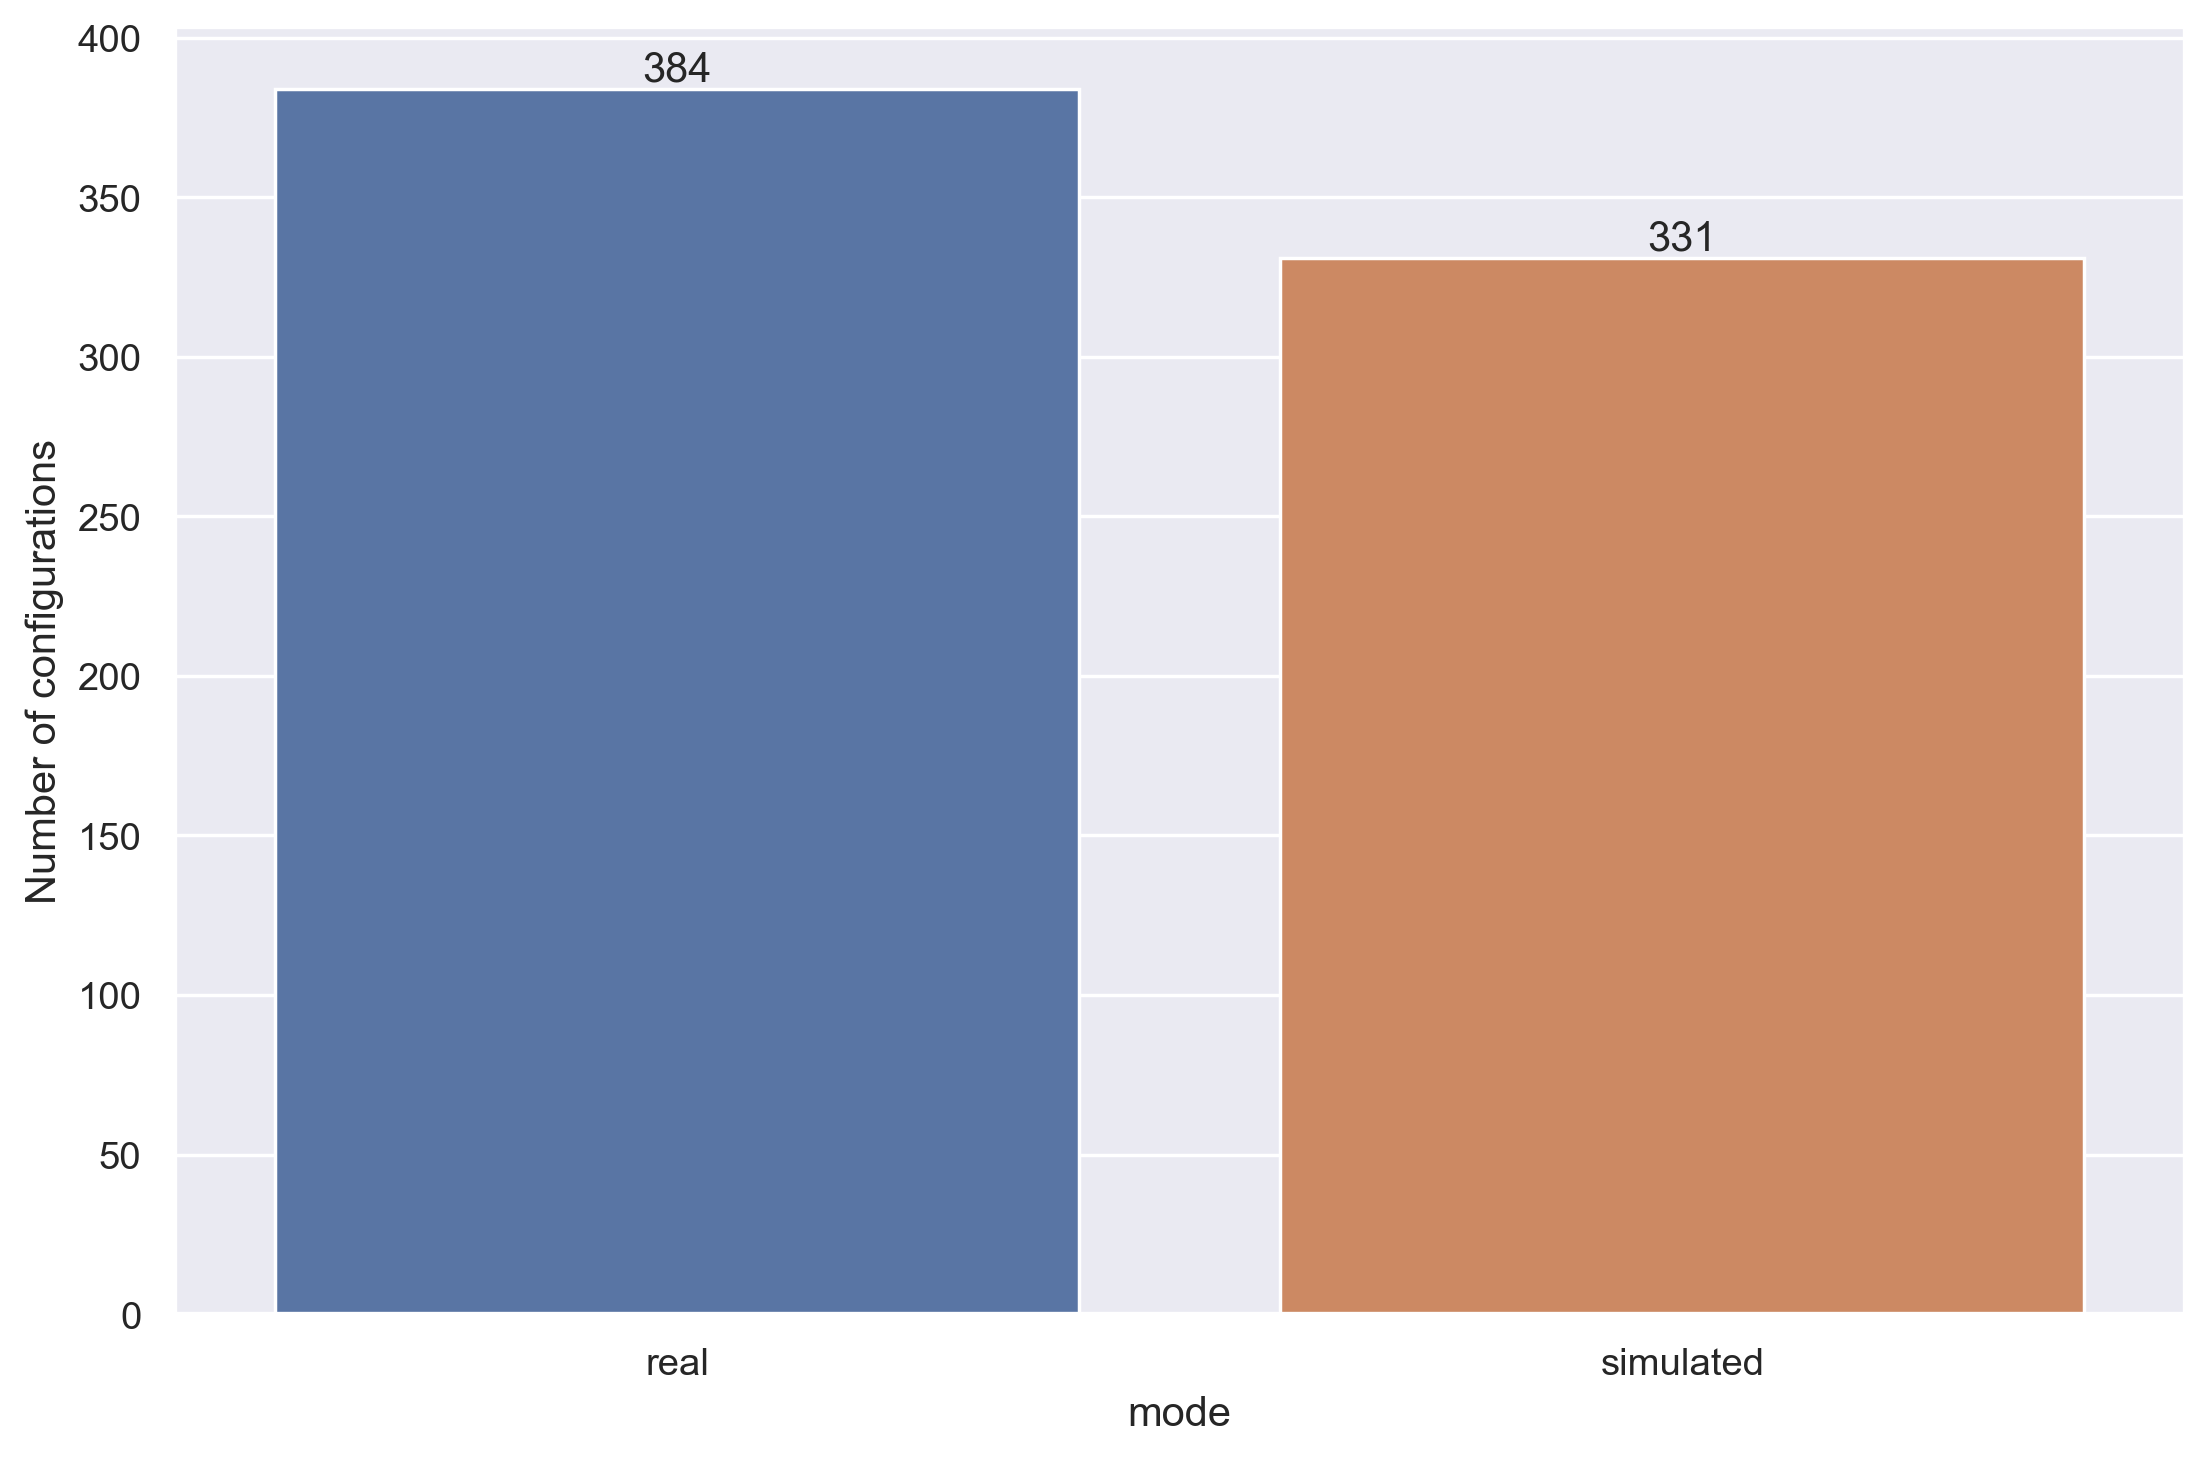

In [22]:
fig = plt.gcf()
fig.set_size_inches(9, plot_height)
fig.set_dpi(plot_dpi)
g = sns.countplot(data=df_cache, x='mode')
g.set_ylabel("Number of configurations")
g.bar_label(g.containers[0])
plt.tight_layout()
plt.savefig(savedirectory / "Q2_count")

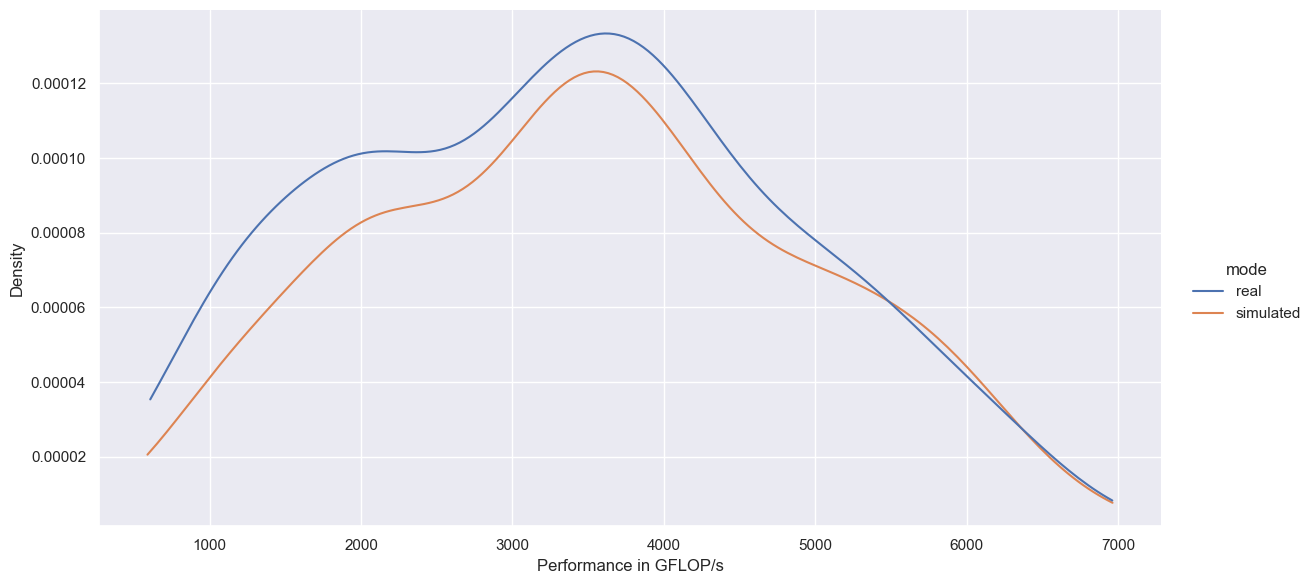

In [6]:
g = sns.displot(data=df_cache, x='GFLOP/s', hue='mode', kind='kde', fill=False, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Performance in GFLOP/s")
g.savefig(savedirectory / "Q2_performance_gflops")

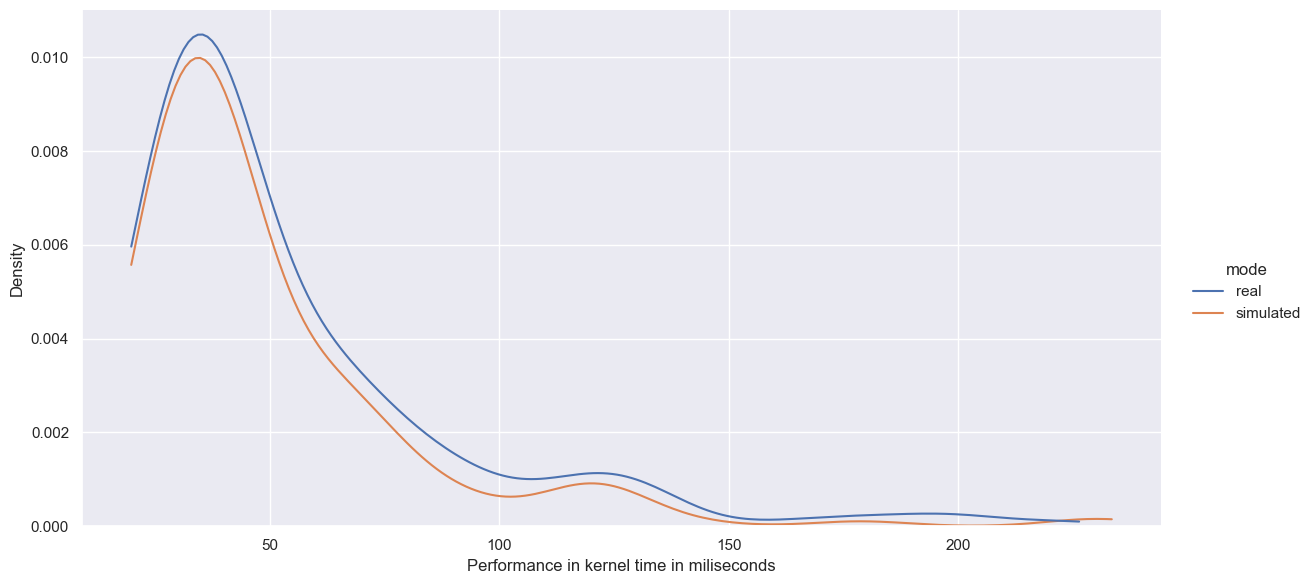

In [7]:
g = sns.displot(data=df_cache, x='time', hue='mode', kind='kde', fill=False, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Performance in kernel time in miliseconds")
g.savefig(savedirectory / "Q2_performance_time")

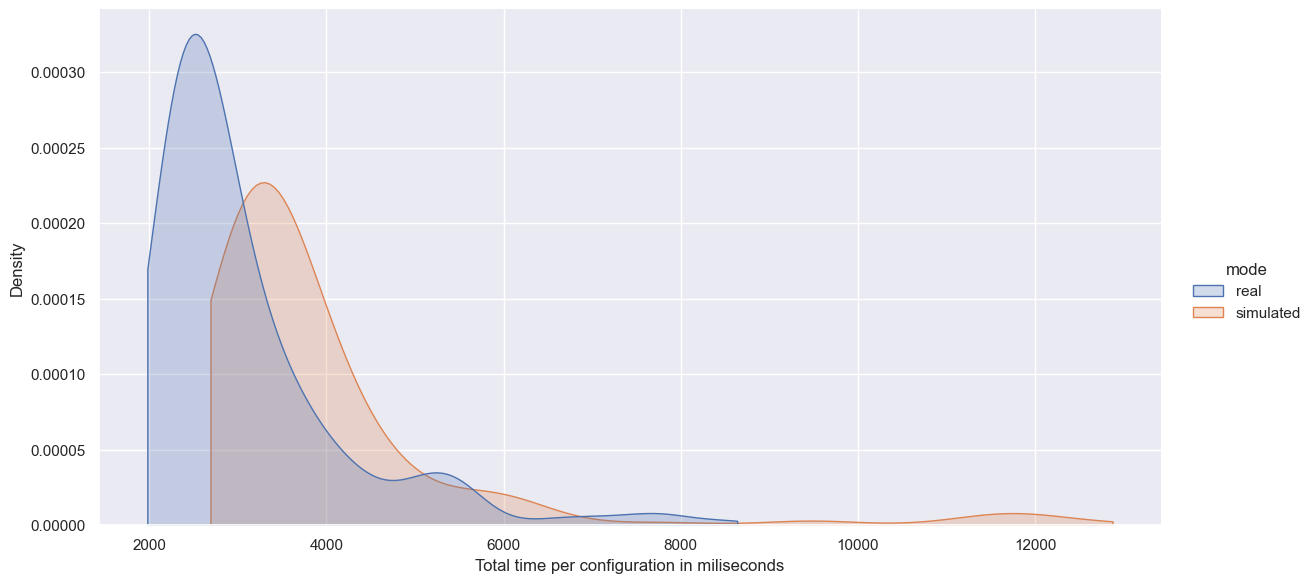

In [26]:
g = sns.displot(data=df_cache, x='total_time', hue='mode', kind='kde', fill=True, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Total time per configuration in miliseconds")
# g.savefig(savedirectory / "performance_distribution_time_per_config")

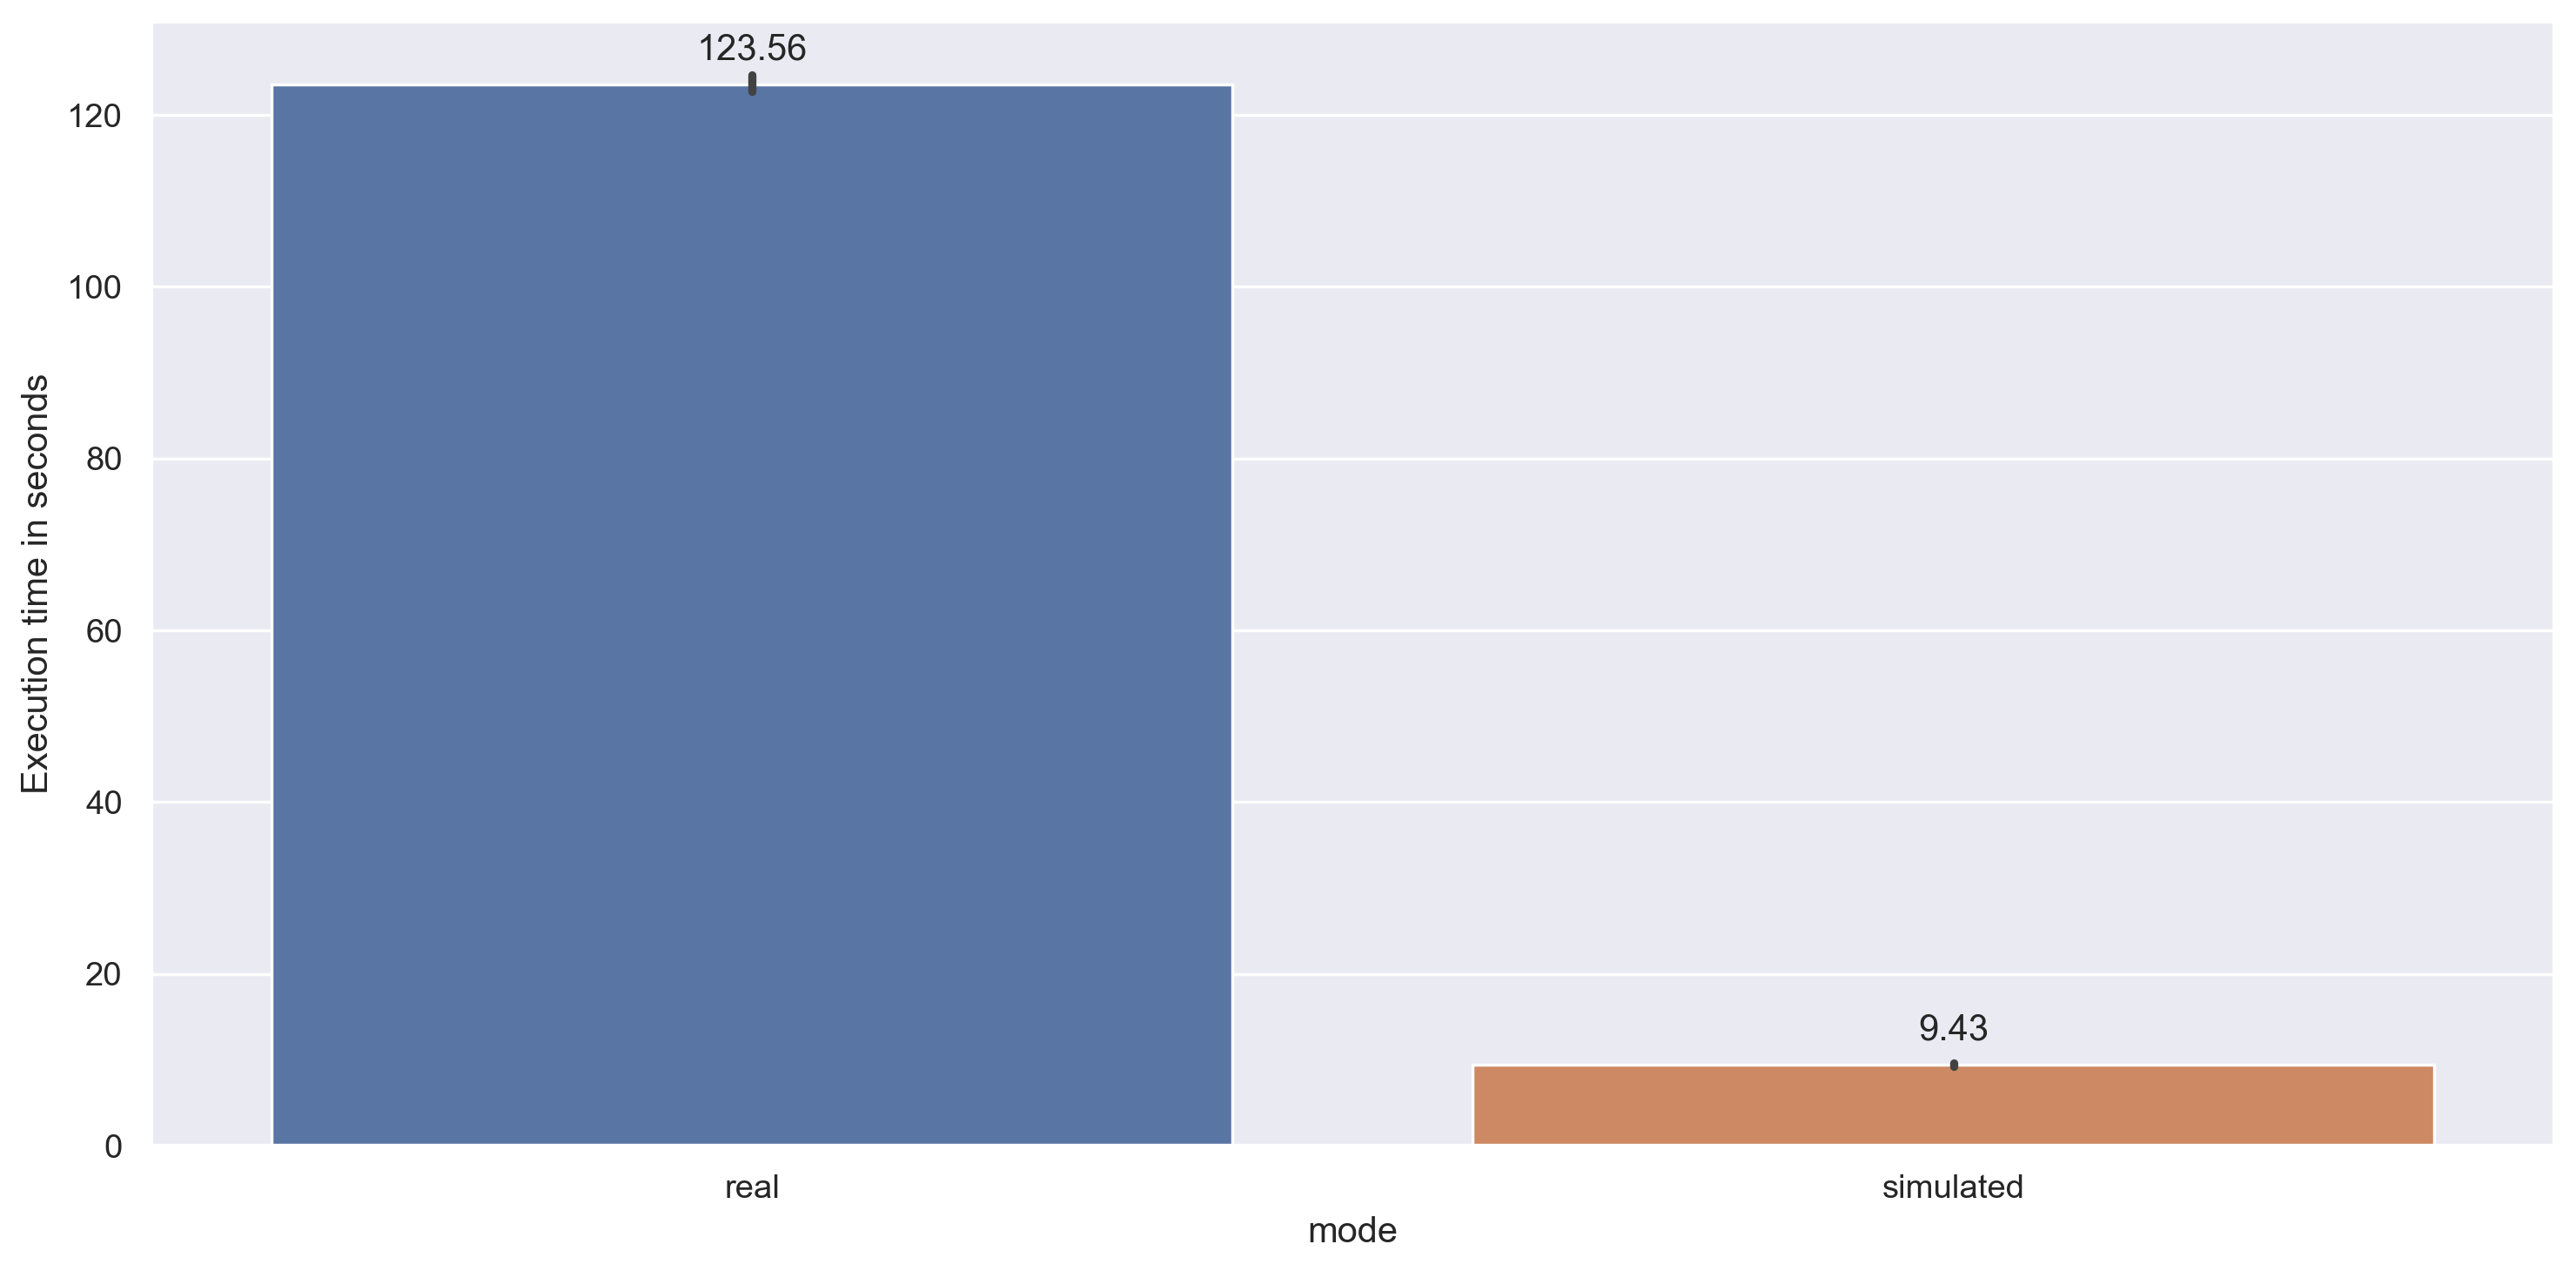

In [9]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height), dpi=plot_dpi)
g = sns.barplot(data=df_env.round(1), x='mode', y="execution_time")
g.bar_label(g.containers[0], padding=6.0)
g.set_ylabel("Execution time in seconds")
plt.tight_layout()
plt.savefig(savedirectory / "Q3_execution_time_spent")